# K-Medoids Clustering for Smart Meter Customer Segmentation

In [82]:
import polars as pl
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
from importlib import reload
import pandas as pd
import cluster_statistics_kMed # Custom module for cluster analysis
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

import numpy as np
from kmedoids import KMedoids
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score, pairwise_distances
#import gower


### 1. CONFIGURATION: Dataset selection and hyperparameters

In [83]:
# Defines analysis scope: SWW/GroupE datasets, building types, feature sets, clusters, weighting

main_path = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern"
dataset = "GroupE"  # Options: "SWW", "GroupE"
building_type = "house" # "flat", "house", "all"
categorical_features = "technical"  # "technical", "sociodemographic"
number_of_clusters = 5  # Optimal k from silhouette analysis
weighting_alpha = 0.25  # Distance weighting: 0=categorical only, 1=time series only

print(f"Dataset: {dataset}, Building: {building_type}, Features: {categorical_features}, k={number_of_clusters}, α={weighting_alpha}")

Dataset: GroupE, Building: house, Features: technical, k=5, α=0.25


### 2. TIME SERIES DATA: Load hourly smart meter consumption (96 timestamps = 1 day)

In [84]:
# Loads normalized hourly data, filters for complete 96h profiles, reshapes to (nsamples, 96, 1)

# Ensures data integrity for temporal clustering; skips incomplete files

pattern = (f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/SM_DATA_hourlyAveraged_normalized/*.csv')
file_paths = glob.glob(pattern)
n_timestamps = 96
data_list = []
filename_list = []

for file_path in file_paths:
    df = pl.read_csv(file_path)

    base = os.path.basename(file_path)
    resid, _ = os.path.splitext(base) 

    # Data quality filter: exact 96 timestamps required
    if len(df) != n_timestamps:
        continue
    
    # Extract daily average consumption, normalize shape for 3D stacking
    values_array = (
        df["day_avg_bruttolastgang_kwh"]
        .to_numpy()
        .reshape((1, n_timestamps, 1))
    )
    data_list.append(values_array)
    filename_list.append(resid)

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")
    train_data = data_3d
else:
    train_data = None
    print("No matching files with correct length found.")

n_samples = data_3d.shape[0]

Shape of the 3D array: (379, 96, 1)


### 3. SURVEY DATA: Load sociodemographic/technical features from Excel

In [85]:
# Dataset-specific column extraction due to varying survey structures

# Validates 1:1 mapping between time series households and survey entries

file_path = (f"{main_path}/DATA/{dataset}/Survey_Data/Survey_Data_{dataset}.xlsx")

# Datasets have different survey structure

if dataset == "SWW":
    # SWW survey: specific row/column structure
    df = pd.read_excel(file_path, skiprows=4, nrows=1500, header=None,dtype={10: str})
    cols_to_extract = [10, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 154, 127, 129, 155, 131, 128, 156, 157, 158, 159, 160]
elif dataset == "GroupE":
    # GroupE survey: specific row/column structure
    df = pd.read_excel(file_path, skiprows=3, nrows=1500, header=None,dtype={0: str})
    cols_to_extract = [0, 148, 149, 150, 151, 152, 153, 154, 155, 156, 158, 160, 134, 136, 161, 138, 135, 162, 163, 154, 155, 166]

extracted_df = df.iloc[:, cols_to_extract]

# Assign headers
extracted_df.columns = ['resident_id', 'Building Type', 'Heating', 'Water Heating', 
                        'Solar Panels', 'Electric Vehicle', 'Heat Pump', 'Individual Electric Boiler', 
                        'Individual Washing Machine', 'Home Battery','Number of Residents',
                        'Number of Days at Home','Age','Education', 'Employment', 'Tenant Type',
                        'Income','DR scenario', 'DR heating', 'DR hot water', 'DR EV', 'DR appliances']

extracted_df_pl = pl.from_pandas(extracted_df)

# Data integrity check
total_rows = extracted_df_pl.height
unique_house_ids = extracted_df_pl["resident_id"].n_unique()

print(f"Total rows: {total_rows}")
print(f"Unique resident_id count: {unique_house_ids}")

if total_rows > unique_house_ids:
    print(f"There are {total_rows - unique_house_ids} duplicate resident_id entries.")
else:
    print("No duplicates found in resident_id column.")


# Ensure the same order between time series data and categorical data

result_df = extracted_df
result_df = pl.from_pandas(result_df)

order_dict = {resident_id: i for i, resident_id in enumerate(filename_list)}
ordered_rows = [result_df.filter(pl.col("resident_id") == filename) for filename in filename_list]
ordered_result_df = pl.concat(ordered_rows)

Total rows: 379
Unique resident_id count: 379
No duplicates found in resident_id column.


### 4. CATEGORICAL ENCODING: Integer encoding

In [86]:
# Uses pandas CategoricalDtype for ordinal encoding
# Filters by building type (house/flat/all), excludes "No Information" responses
# Encodes via cat.codes for Gower distance computation

from pandas.api.types import CategoricalDtype

# Select feature columns based on analysis scope
if categorical_features == "technical":
    if building_type == "house":
        # House-specific technical features
        category_df = ordered_result_df.select(['Building Type', 'Solar Panels', 'Electric Vehicle','Heating', 
                                            'Water Heating', 'Home Battery']).to_pandas().astype('category')
    
    elif building_type == "flat":
        # Flat-specific technical features
        category_df = ordered_result_df.select(['Building Type', 'Individual Electric Boiler', 
                                            'Individual Washing Machine']).to_pandas().astype('category')
        
else:   # sociodemographic features
    category_df = ordered_result_df.select(['Building Type','Tenant Type', 'Age', 'Income', 'Education', 
                                        'Employment', 'Number of Residents','Number of Days at Home']).to_pandas().astype('category')

# Define categories for each categorical feature
days_at_home_categories = ['No Information', '<25%', '25-50%', '>50-75%', '>75%']
building_type_categories = ['No Information', 'Flat', 'House']
heating_categories = ['No Information', 'Other', 'Heat Pump', 'Boiler']
water_heating_categories = ['No Information', 'Other', 'Heat Pump', 'Boiler']
solar_panels_categories = ['No Information', 'No', 'Yes']
electric_vehicle_categories = ['No Information', 'No', 'Yes']
number_of_days_at_home_categories = ['No Information', '0', '1', '2', '3', '4', '5', '6', '7']
home_battery_categories = ['No Information', 'No', 'Yes']
heat_pump_categories = ['No Information', 'No', 'Yes']

electric_boiler_categories = ['No Information', 'No', 'Yes']
washing_machine_categories = ['No Information', 'No', 'Yes']

building_type_categories = ['No Information', 'Flat', 'House']
tenant_type_categories = ['Living in a cooperative', 'Tenant', 'Owner']
age_categories = ['18-35 years old', '36 - 50 years old', '51 - 65 years old', 'More than 65 years old']
income_categories = ['I prefer not to say', 'Less than 4,000', '4,000-5,999','6000-9999','10000 CHF or more' ]
education_categories = ['Mandatory school', 'Secondary degree (Apprenticeship, high school et commercial/general culture school)'
                        , 'Tertiary degree  (Superior school (ES), University/EPF, vocational university)']
employment_categories = ['Employed', 'Unemployed', 'Retired']
number_of_residents_categories = ['1', '2', '3', '4', '> 4']
number_of_days_at_home_categories = ['0', '1', '2', '3', '4', '5', '6', '7']


building_cat_type = CategoricalDtype(categories=building_type_categories, ordered=True)
heating_cat_type = CategoricalDtype(categories=heating_categories, ordered=True)
water_heating_cat_type = CategoricalDtype(categories=water_heating_categories, ordered=True)
solar_cat_type = CategoricalDtype(categories=solar_panels_categories, ordered=True)
ev_cat_type = CategoricalDtype(categories=electric_vehicle_categories, ordered=True)
number_of_days_cat_type = CategoricalDtype(categories=number_of_days_at_home_categories, ordered=True)
home_battery_cat_type = CategoricalDtype(categories=home_battery_categories, ordered=True)
heat_pump_cat_type = CategoricalDtype(categories=heat_pump_categories, ordered=True)

electric_boiler_cat_type = CategoricalDtype(categories=electric_boiler_categories, ordered=False)
washing_machine_cat_type = CategoricalDtype(categories=washing_machine_categories, ordered=False)

building_cat_type = CategoricalDtype(categories=building_type_categories, ordered=True)
tenant_cat_type = CategoricalDtype(categories=tenant_type_categories, ordered=True)
age_cat_type = CategoricalDtype(categories=age_categories, ordered=True)
income_cat_type = CategoricalDtype(categories=income_categories, ordered=True)
education_cat_type = CategoricalDtype(categories=education_categories, ordered=True)
employment_cat_type = CategoricalDtype(categories=employment_categories, ordered=True)
number_of_residents_cat_type = CategoricalDtype(categories=number_of_residents_categories, ordered=True)
number_of_days_at_home_cat_type = CategoricalDtype(categories=number_of_days_at_home_categories, ordered=True)


if categorical_features == "technical":
    if building_type == "house":
        category_df['Building Type'] = category_df['Building Type'].astype(building_cat_type)
        category_df['Heating'] = category_df['Heating'].astype(heating_cat_type)
        category_df['Water Heating'] = category_df['Water Heating'].astype(water_heating_cat_type)
        category_df['Solar Panels'] = category_df['Solar Panels'].astype(solar_cat_type)
        category_df['Electric Vehicle'] = category_df['Electric Vehicle'].astype(ev_cat_type)
        category_df['Home Battery'] = category_df['Home Battery'].astype(home_battery_cat_type)
    elif building_type == "flat":
        category_df['Building Type'] = category_df['Building Type'].astype(building_cat_type)
        category_df['Individual Electric Boiler'] = category_df['Individual Electric Boiler'].astype(electric_boiler_cat_type)
        category_df['Individual Washing Machine'] = category_df['Individual Washing Machine'].astype(washing_machine_cat_type)

else:
    category_df['Building Type'] = category_df['Building Type'].astype(building_cat_type)
    category_df['Tenant Type'] = category_df['Tenant Type'].astype(tenant_cat_type)
    category_df['Age'] = category_df['Age'].astype(age_cat_type)
    category_df['Income'] = category_df['Income'].astype(income_cat_type)
    category_df['Education'] = category_df['Education'].astype(education_cat_type)
    category_df['Employment'] = category_df['Employment'].astype(employment_cat_type)
    category_df['Number of Residents'] = category_df['Number of Residents'].astype(number_of_residents_cat_type)
    category_df['Number of Days at Home'] = category_df['Number of Days at Home'].astype(number_of_days_at_home_cat_type)


# Filter valid households (exclude "No Information" + wrong building type)
rows_to_keep_indices = []
exclude_building_type = building_type

if building_type == "all":
    exclude_building_type = None
elif building_type == "house":
    exclude_building_type = "Flat"
elif building_type == "flat":
    exclude_building_type = "House"

if building_type != "all":
    for i, row in category_df.iterrows():
        # Check if 'No Information' NOT in any value of that row
        if "No Information" not in row.values:
            # Check if 'Flat' NOT in any value of that row
            if exclude_building_type not in row.values:
                rows_to_keep_indices.append(i)
else:
    for i, row in category_df.iterrows():
        rows_to_keep_indices.append(i)

category_df = category_df.drop(columns=['Building Type'])

for col in category_df.columns:
    category_df[col] = category_df[col].cat.codes

category_array = category_df.to_numpy()

# Prepare time series: squeeze 3rd dimension, filter matching indices
time_series_numeric = data_3d[:, :, 0].reshape(n_samples, n_timestamps)

# Combine horizontally
combined_data = np.hstack([time_series_numeric, category_df])

# Filter both arrays using the collected indices to keep
cleaned_combined_data = combined_data[rows_to_keep_indices]
time_series_numeric = time_series_numeric[rows_to_keep_indices]
combined_data = cleaned_combined_data

filename_list = [filename_list[i] for i in rows_to_keep_indices]
print(f"Number of samples after cleaning: {combined_data.shape[0]}")

Number of samples after cleaning: 209


In [87]:
# Specify the categorical feature column indices

if categorical_features == "technical":
    if building_type == "house":
        number_of_categories = 5
    else:
        number_of_categories = 2
else:
    number_of_categories = 7

categorical_indices = list(range(combined_data.shape[1] - number_of_categories, combined_data.shape[1]))
numerical_indices = list(range(0, combined_data.shape[1]-number_of_categories))

### 6. K-MEDOIDS CLUSTERING: Optimal k from silhouette analysis

In [88]:
# Uses fasterpam method (approximate PAM, faster for large n)
# Validates via silhouette score (higher = better cluster separation)

n_samples = combined_data.shape[0]
n_timestamps = 96

time_series_numeric = data_3d.squeeze(axis=2)      # (n_samples, n_timestamps)
time_series_numeric = time_series_numeric[rows_to_keep_indices]

# -- Compute categorical distance matrix (Hamming/fraction mismatches) --
#cat_dist_mat = gower.gower_matrix(combined_data[:,categorical_indices])
cat_dist_mat = squareform(pdist(combined_data[:,categorical_indices], metric='hamming'))
# -- Numeric distance matrix (Euclidean) --
num_dist_mat = pairwise_distances(time_series_numeric, metric='euclidean')

# -- Normalize distances to [0,1] --
num_dist_mat /= num_dist_mat.max() if num_dist_mat.max() > 0 else 1

# -- Combine with weight alpha --
alpha = weighting_alpha
combined_dist_mat = alpha * num_dist_mat + (1 - alpha) * cat_dist_mat

k = number_of_clusters
model = KMedoids(n_clusters=k, metric='precomputed', method='fasterpam', random_state=42)
model.fit(combined_dist_mat)
labels = model.labels_
medoids = model.medoid_indices_

clusters = labels +1

sil_score = silhouette_score(combined_dist_mat, labels, metric='precomputed')
print(f'Silhouette score: {sil_score:.3f}')

Silhouette score: 0.390


### 7. VISUALIZATION: Cluster silhouette scores vs k and α

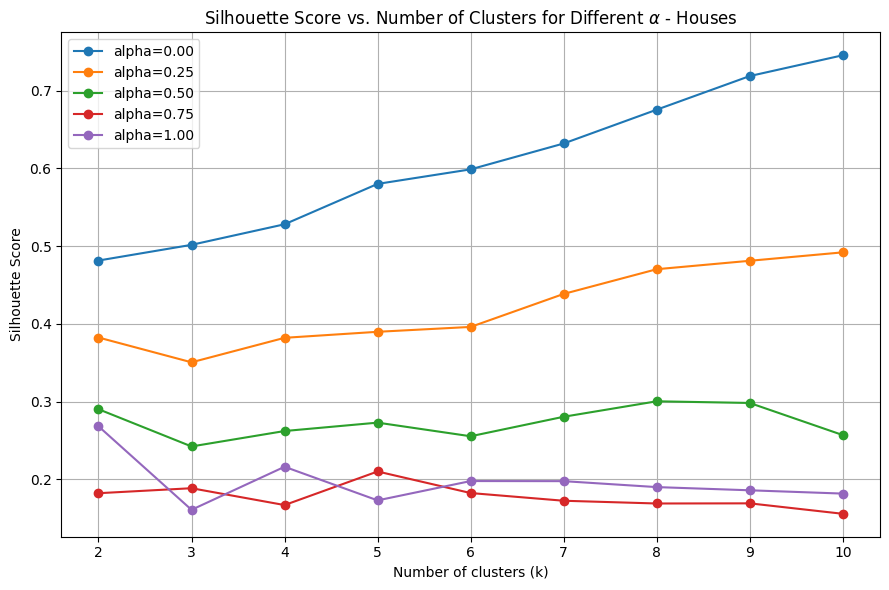

In [89]:
#%%skip

# Silhouette analysis over varying k and alpha

n_samples = combined_data.shape[0]

time_series_numeric = data_3d.squeeze(axis=2) 
time_series_numeric = time_series_numeric[rows_to_keep_indices]

cat_dist_mat = np.zeros((n_samples, n_samples))
num_dist_mat = pairwise_distances(time_series_numeric, metric='euclidean')
cat_dist_mat = squareform(pdist(combined_data[:,categorical_indices], metric='hamming'))
num_dist_mat /= num_dist_mat.max() if num_dist_mat.max() > 0 else 1

alphas = np.linspace(0.00, 1, 5)
k_values = range(2, 11)  

# Store silhouette scores in a (len(k_values), len(alphas)) array
silhouette_scores = np.zeros((len(k_values), len(alphas)))

for a_idx, alpha in enumerate(alphas):
    combined_dist_mat = alpha * num_dist_mat + (1 - alpha) * cat_dist_mat
    #combined_dist_mat = alpha*num_dist_mat + cat_dist_mat
    for k_idx, k in enumerate(k_values):
        model = KMedoids(n_clusters=k, metric="precomputed", method='fasterpam', random_state=42)
        model.fit(combined_dist_mat)
        labels = model.labels_
        sil_score = silhouette_score(combined_dist_mat, labels, metric="precomputed")
        silhouette_scores[k_idx, a_idx] = sil_score
        #print(f"k={k}, alpha={alpha:.2f}, silhouette={sil_score:.3f}")

plt.figure(figsize=(9, 6))
for a_idx, alpha in enumerate(alphas):
    plt.plot(list(k_values), silhouette_scores[:, a_idx], marker='o', label=f'alpha={alpha:.2f}')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title(rf'Silhouette Score vs. Number of Clusters for Different $\alpha$ - {building_type.capitalize()}s', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{main_path}/Results/{dataset}/Plots/Cluster/kMedoids_SC_{building_type}_{categorical_features}.png')
plt.show()

### 8. RESULTS EXPORT: Cluster assignments with household IDs

In [90]:
# Saves sorted cluster results for demand response analysis
# Remaps cluster labels if needed for interpretability

if categorical_features == "technical":
    if building_type == "house":
        remap = {6: 6, 3: 2, 1: 5, 2: 1, 4: 3, 5: 4}
        clusters = np.vectorize(remap.get)(clusters)
    else:
        remap = {4: 1, 2: 2, 1: 4, 3: 3}
        clusters = np.vectorize(remap.get)(clusters)

# Convert filename_list items to strings
resident_ids = [str(h) for h in filename_list]

# Creates Polars DataFrame with house IDs and clusters
result_df = pl.DataFrame({
    "resident_id": resident_ids,
    "cluster": clusters
}).sort("cluster")

result_df.write_csv(f"{main_path}/Results/{dataset}/DATA/Cluster/hourly_avg_clustering_kMed_{building_type}_{categorical_features}.csv")

### 9. ANALYSIS: Visualization of consumption profiles, statistical analysis, PAR calculation, distribution of features

Cluster 1 size: 37
Cluster 2 size: 76
Cluster 3 size: 24
Cluster 4 size: 52
Cluster 5 size: 20


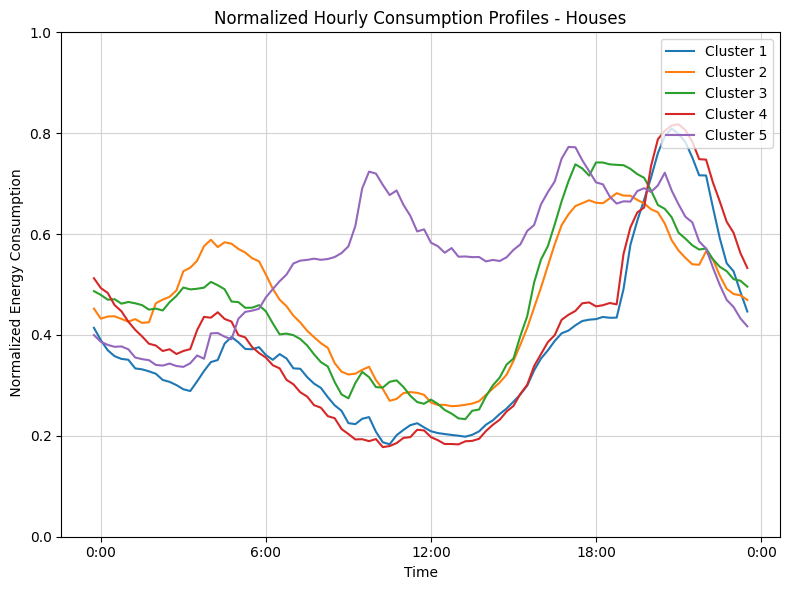

In [91]:
unique_clusters = np.unique(clusters)

labels = ['0:00','6:00','12:00','18:00','0:00']
colors= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize=(8, 6))
for cl in unique_clusters:
    idx = np.where(clusters == cl)[0]
    avg_profile = time_series_numeric[idx].mean(axis=0)
    plt.plot(avg_profile, label=f'Cluster {cl}')
    print(f'Cluster {cl} size: {len(idx)}')

plt.title(f"Normalized Hourly Consumption Profiles - {building_type.capitalize()}s", fontsize=12)
plt.xlabel("Time")
plt.ylabel(" Normalized Energy Consumption")
plt.ylim(0,1)
#plt.xticks(range(1,108,12),labels=labels)
plt.xticks(range(1,120,24),labels=labels)
plt.tight_layout()
#plt.legend()
#plt.margins(0)
plt.grid(True, color = 'lightgray')
plt.legend(
    #title='Category',
    loc='upper right',
    bbox_to_anchor=(1, 1),  # Adjust this value for vertical position
    ncol=1,
    fontsize='medium'
)
plt.tight_layout()
plt.savefig(
    f"{main_path}/Results/{dataset}/Plots/Cluster/HourlyAveraged_KMed_{building_type}_{categorical_features}.png",
    bbox_inches='tight'
    )
plt.show()



Cluster 1 size: 37 
Cluster 2 size: 76 
Cluster 3 size: 24 (SELECTED)
Cluster 4 size: 52 (SELECTED)
Cluster 5 size: 20 


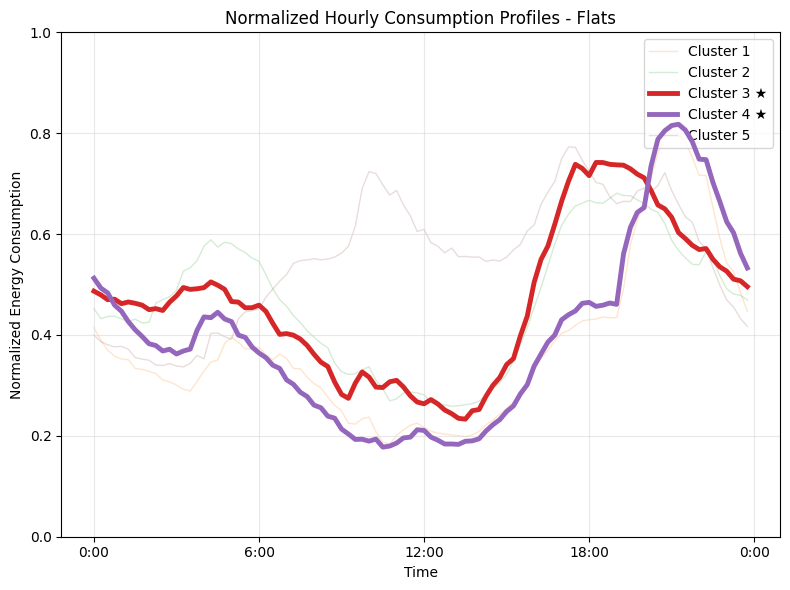

In [92]:
# Plot consumption profiles with interactive cluster selection

def plot_cluster_profiles_selective(
    clusters, 
    time_series_numeric, 
    building_type,
    categorical_features,
    main_path,
    selected_clusters=None,
    colors=None
):
    unique_clusters = np.unique(clusters)
    
    if colors is None:
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                  '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    labels = ['0:00', '6:00', '12:00', '18:00', '0:00']
    
    plt.figure(figsize=(8, 6))
    
    for cl in unique_clusters:
        idx = np.where(clusters == cl)[0]
        avg_profile = time_series_numeric[idx].mean(axis=0)
        
        is_selected = selected_clusters is not None and cl in selected_clusters
        
        if is_selected:
            alpha = 1.0
            linewidth = 3.5
            zorder = 10
        else:
            alpha = 0.20
            linewidth = 1
            zorder = 1
        
        plt.plot(
            avg_profile,
            label=f'Cluster {cl}' + (" ★" if is_selected else ""),
            color=colors[cl % len(colors)],
            linewidth=linewidth,
            alpha=alpha,
            zorder=zorder
        )
        
        status = "(SELECTED)" if is_selected else ""
        print(f'Cluster {cl} size: {len(idx)} {status}')
    
    plt.title(
        f"Normalized Hourly Consumption Profiles - {building_type.capitalize()}s",
        fontsize=12
    )
    plt.xlabel("Time")
    plt.ylabel("Normalized Energy Consumption")
    plt.ylim(0, 1)
    plt.xticks(range(0, 120, 24), labels=labels)
    plt.grid(True, color='lightgray', alpha=0.5)
    plt.legend(loc='upper right', ncol=1, fontsize='medium')
    plt.tight_layout()
    plt.show()

# Generate results with selected clusters highlighted
plot_cluster_profiles_selective(
    clusters, 
    time_series_numeric, 
    building_type='flat',
    categorical_features='technical',
    main_path='/path/to/main',
    selected_clusters=[3,4],
    colors=colors
)

(209, 96, 1)


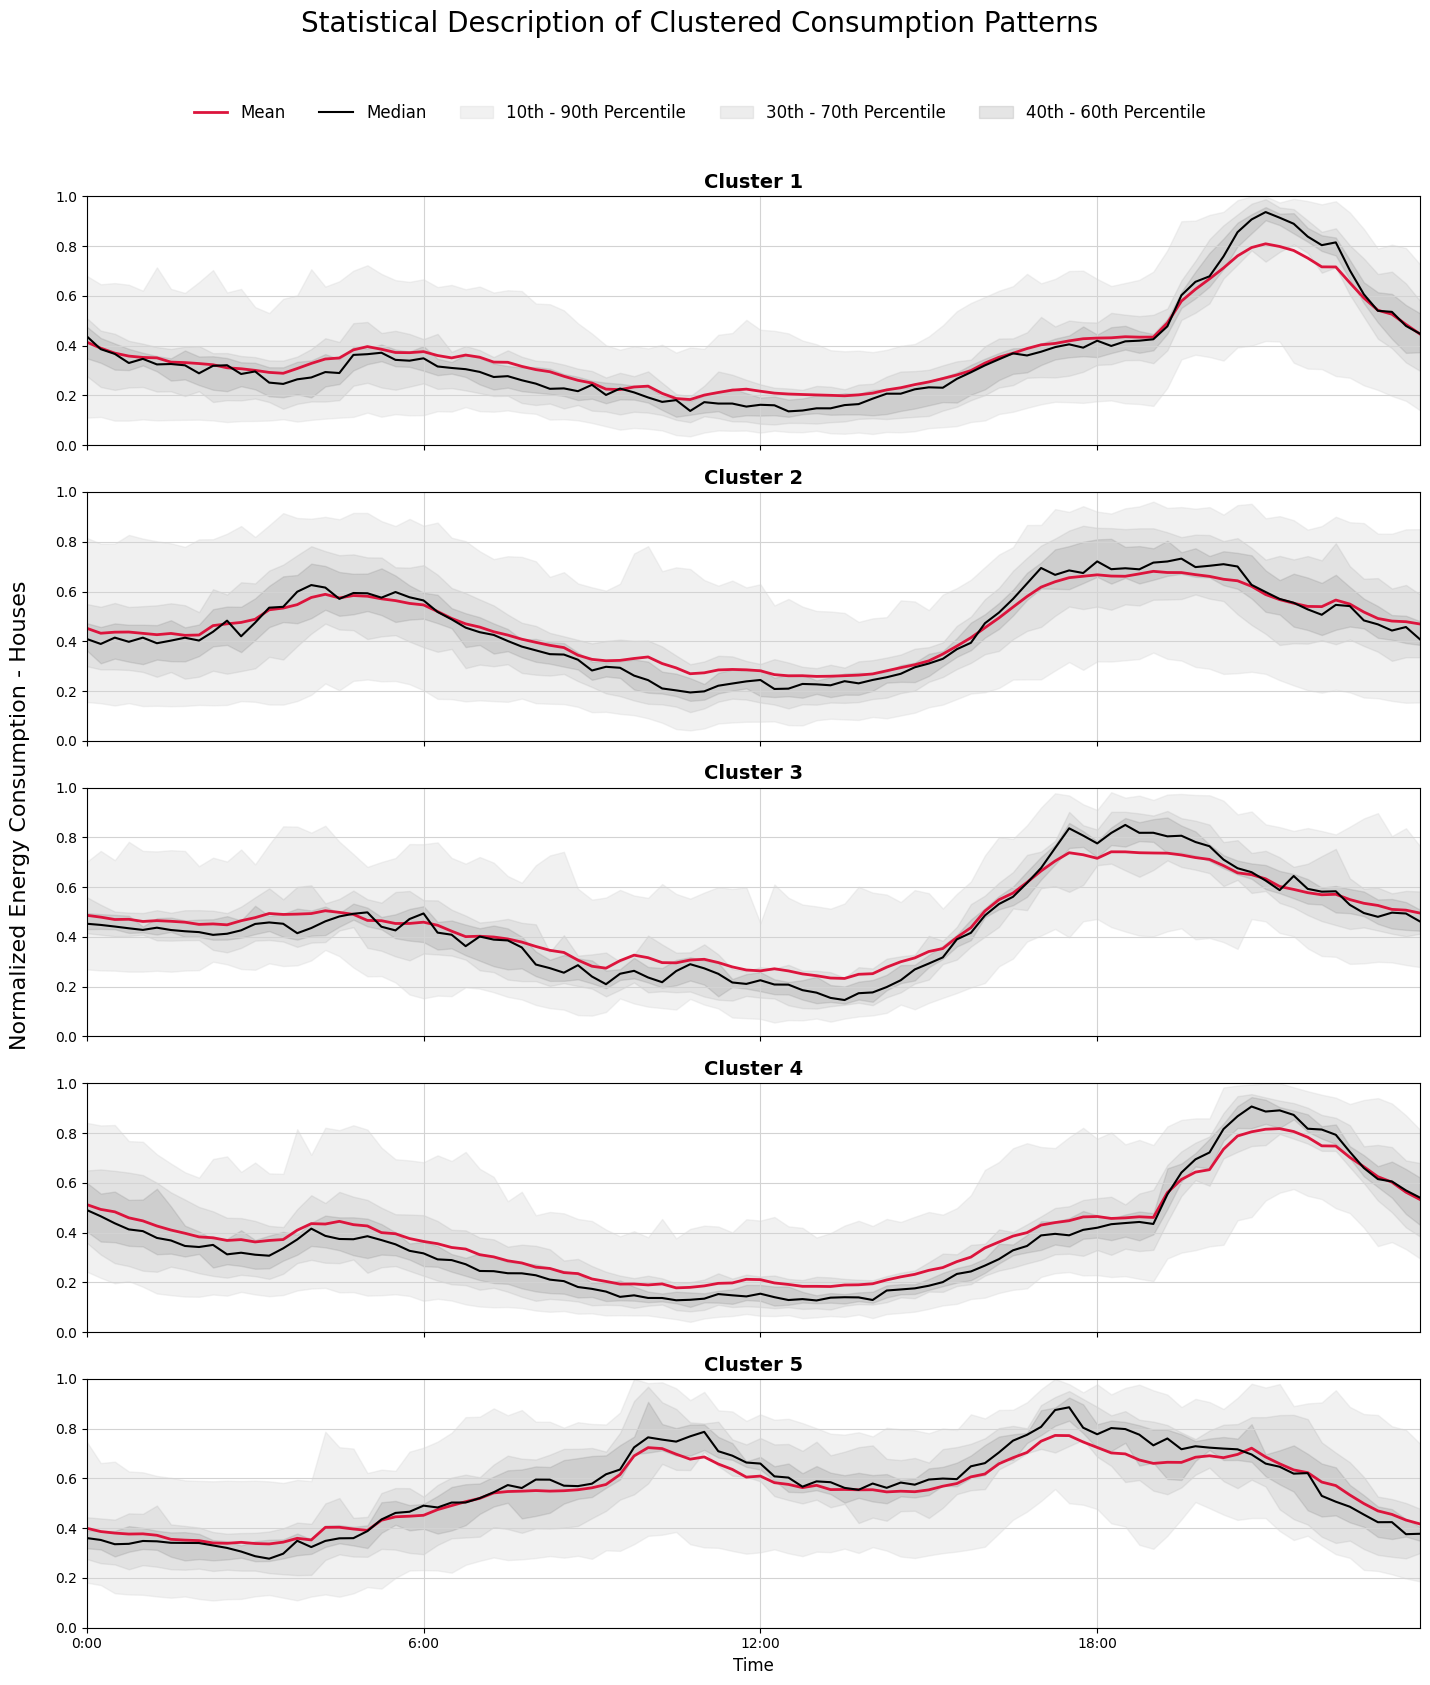

In [93]:
# Generate statistical summaries for clusters

reload(cluster_statistics_kMed)

from cluster_statistics_kMed import plot_cluster_percentiles

data_3d_kProt = np.expand_dims(time_series_numeric, axis=-1)

print(data_3d_kProt.shape)

for i in range(number_of_clusters):

    i = i+1
    cluster_data = time_series_numeric[clusters == i]
    
    if cluster_data.shape[0] == 0:
        print(f"Warning: cluster {i} is empty, skipping.")
        continue

plot_cluster_percentiles(data_3d_kProt,clusters,number_of_clusters, building_type, dataset, categorical_features)

In [94]:
# Generate cluster summary statistics

result_df = pl.read_csv(f'{main_path}/Results/{dataset}/DATA/Cluster/hourly_avg_clustering_kMed_{building_type}_{categorical_features}.csv')

# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv(f"{main_path}/DATA/{dataset}/alle_mittelwerte.csv") 

# Normalize keys in all DataFrames for clean join
result_df = result_df.with_columns(
    pl.col("resident_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("resident_id")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("resident_id")
)

result_df = result_df.join(
    alle_mittelwerte_df.select([
        "resident_id",
        "bruttolastgang_kwh_sum",
        "average_daily_consumption",
        "average_hourly_consumption",
        "bruttolastgang_kwh_max"
    ]),
    on="resident_id",
    how="left"
)
result_df = result_df.select([
    "resident_id",
    "cluster",
    "bruttolastgang_kwh_sum",
    "average_daily_consumption" ,
    "average_hourly_consumption",
    "bruttolastgang_kwh_max"
])

cluster_summary = result_df.group_by("cluster").agg([
    pl.count("resident_id").alias("num_households"),
    pl.mean("bruttolastgang_kwh_sum").alias("avg_total_consumption [kWh]").round(2),
    pl.mean("average_daily_consumption").alias("avg_daily_consumption [kWh]").round(2),
    pl.mean("average_hourly_consumption").alias("avg_hourly_consumption [kWh]").round(2),
    pl.mean("bruttolastgang_kwh_max").alias("avg_max_consumption [kWh]").round(2)
    
]).sort("cluster")

cluster_summary = cluster_summary.with_columns([
    (pl.col("avg_total_consumption [kWh]") * pl.col("num_households")/1000)
        .alias("combined_max_consumption [MWh]")
        .round(2),
    (pl.col("avg_total_consumption [kWh]") * pl.col("num_households"))
        .alias("cluster_total_consumption [kWh]"),
])

cluster_summary = cluster_summary.with_columns([
    (pl.col("num_households") / pl.col("num_households").sum())
        .alias("share_of_households")
        .round(4),
    (pl.col("cluster_total_consumption [kWh]") 
     / pl.col("cluster_total_consumption [kWh]").sum())
        .alias("share_of_total_consumption")
        .round(4),
])

print(cluster_summary)

shape: (5, 10)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ cluster ┆ num_househ ┆ avg_total ┆ avg_daily ┆ … ┆ combined_ ┆ cluster_t ┆ share_of_ ┆ share_of_ │
│ ---     ┆ olds       ┆ _consumpt ┆ _consumpt ┆   ┆ max_consu ┆ otal_cons ┆ household ┆ total_con │
│ i64     ┆ ---        ┆ ion [kWh] ┆ ion [kWh] ┆   ┆ mption    ┆ umption   ┆ s         ┆ sumption  │
│         ┆ u32        ┆ ---       ┆ ---       ┆   ┆ [MWh]     ┆ [kWh…     ┆ ---       ┆ ---       │
│         ┆            ┆ f64       ┆ f64       ┆   ┆ ---       ┆ ---       ┆ f64       ┆ f64       │
│         ┆            ┆           ┆           ┆   ┆ f64       ┆ f64       ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1       ┆ 37         ┆ 4020.06   ┆ 16.62     ┆ … ┆ 148.74    ┆ 148742.22 ┆ 0.177     ┆ 0.1927    │
│ 2       ┆ 76         ┆ 3822.94   ┆ 16.23     ┆ … ┆ 290.54    ┆ 290543.44 ┆

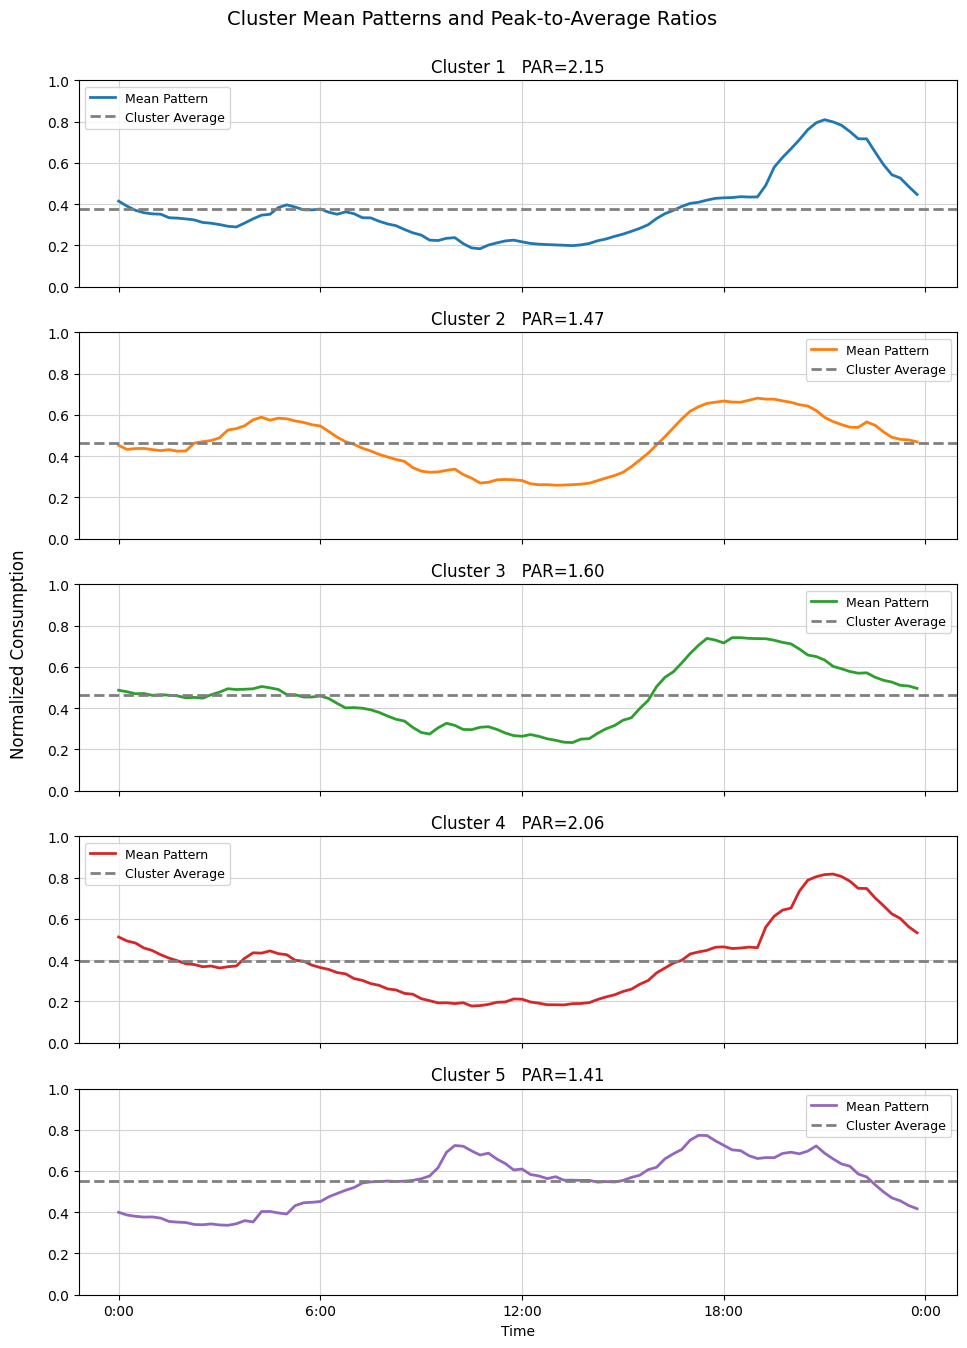

In [95]:
# Plot mean cluster patterns with Peak-to-Average Ratio (PAR)

labels = ['0:00', '6:00', '12:00', '18:00', '0:00']
colors= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

n_clusters_to_plot = np.unique(clusters)
n_clusters = len(n_clusters_to_plot)

fig, axes = plt.subplots(n_clusters, 1, figsize=(10, 2.8 * n_clusters), sharex=True)

if n_clusters == 1:
    axes = [axes]

for idx, cl in enumerate(sorted(n_clusters_to_plot)):
    cluster_idx = np.where(clusters == cl)[0]
    mean_time_series = time_series_numeric[cluster_idx].mean(axis=0)
    PAR_average = np.mean(mean_time_series)
    PAR_max = np.max(mean_time_series)

    ax = axes[idx]
    ax.plot(range(1,97), mean_time_series.ravel()[:96],
            label='Mean Pattern', linewidth=2, color=colors[cl-1])
    ax.axhline(PAR_average, color='grey', linestyle='--', linewidth=2, label='Cluster Average')
    ax.set_title(f"Cluster {cl}   PAR={PAR_max/PAR_average:.2f}",
                 loc='center', fontsize=12, color='black')
    ax.set_ylim(0, 1)
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.grid(color='lightgray', zorder=0)
    ax.legend(fontsize=9)
    if idx == n_clusters-1:
        ax.set_xlabel("Time")
        ax.set_xticks(range(1,120,24))
        ax.set_xticklabels(labels)
    else:
        ax.set_xticks([])

fig.suptitle("Cluster Mean Patterns and Peak-to-Average Ratios", fontsize=14,  y=0.96)
fig.text(0.038, 0.5, "Normalized Consumption", va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.06, 0, 1, 0.96])
plt.savefig(
    f"{main_path}/Results/{dataset}/Plots/Cluster/PAR_KMed_{building_type}_{categorical_features}.png",
    bbox_inches='tight'
)
plt.show()

In [96]:
# Create DataFrame with cluster labels and decoded categorical feature

if categorical_features == "technical":    
    if building_type == "flat":
        df = pd.DataFrame({
            'cluster': clusters,
            'Individual Electric Boiler': [electric_boiler_categories[int(code)] for code in combined_data[:, -2]],
            'Individual Washing Machine': [washing_machine_categories[int(code)] for code in combined_data[:, -1]]
        })
    else:  
        df = pd.DataFrame({
            'cluster': clusters,
            'Solar Panels': [solar_panels_categories[int(code)] for code in combined_data[:, -5]],
            'Electric Vehicle': [electric_vehicle_categories[int(code)] for code in combined_data[:, -4]],
            'Heating': [heating_categories[int(code)] for code in combined_data[:, -3]],
            'Water Heating': [water_heating_categories[int(code)] for code in combined_data[:, -2]],
            'Home Battery': [home_battery_categories[int(code)] for code in combined_data[:, -1]]
        })
else:
    df = pd.DataFrame({
    'cluster': clusters,
    'Tenant Type': [tenant_type_categories[int(code)] for code in combined_data[:, -7]],
    'Age': [age_categories[int(code)] for code in combined_data[:, -6]],
    'Income': [income_categories[int(code)] for code in combined_data[:, -5]],
    'Education': [education_categories[int(code)] for code in combined_data[:, -4]],
    'Employment': [employment_categories[int(code)] for code in combined_data[:, -3]],
    'Number of Residents': [number_of_residents_categories[int(code)] for code in combined_data[:, -2]],
    'Number of Days at Home': [number_of_days_at_home_categories[int(code)] for code in combined_data[:, -1]]
})

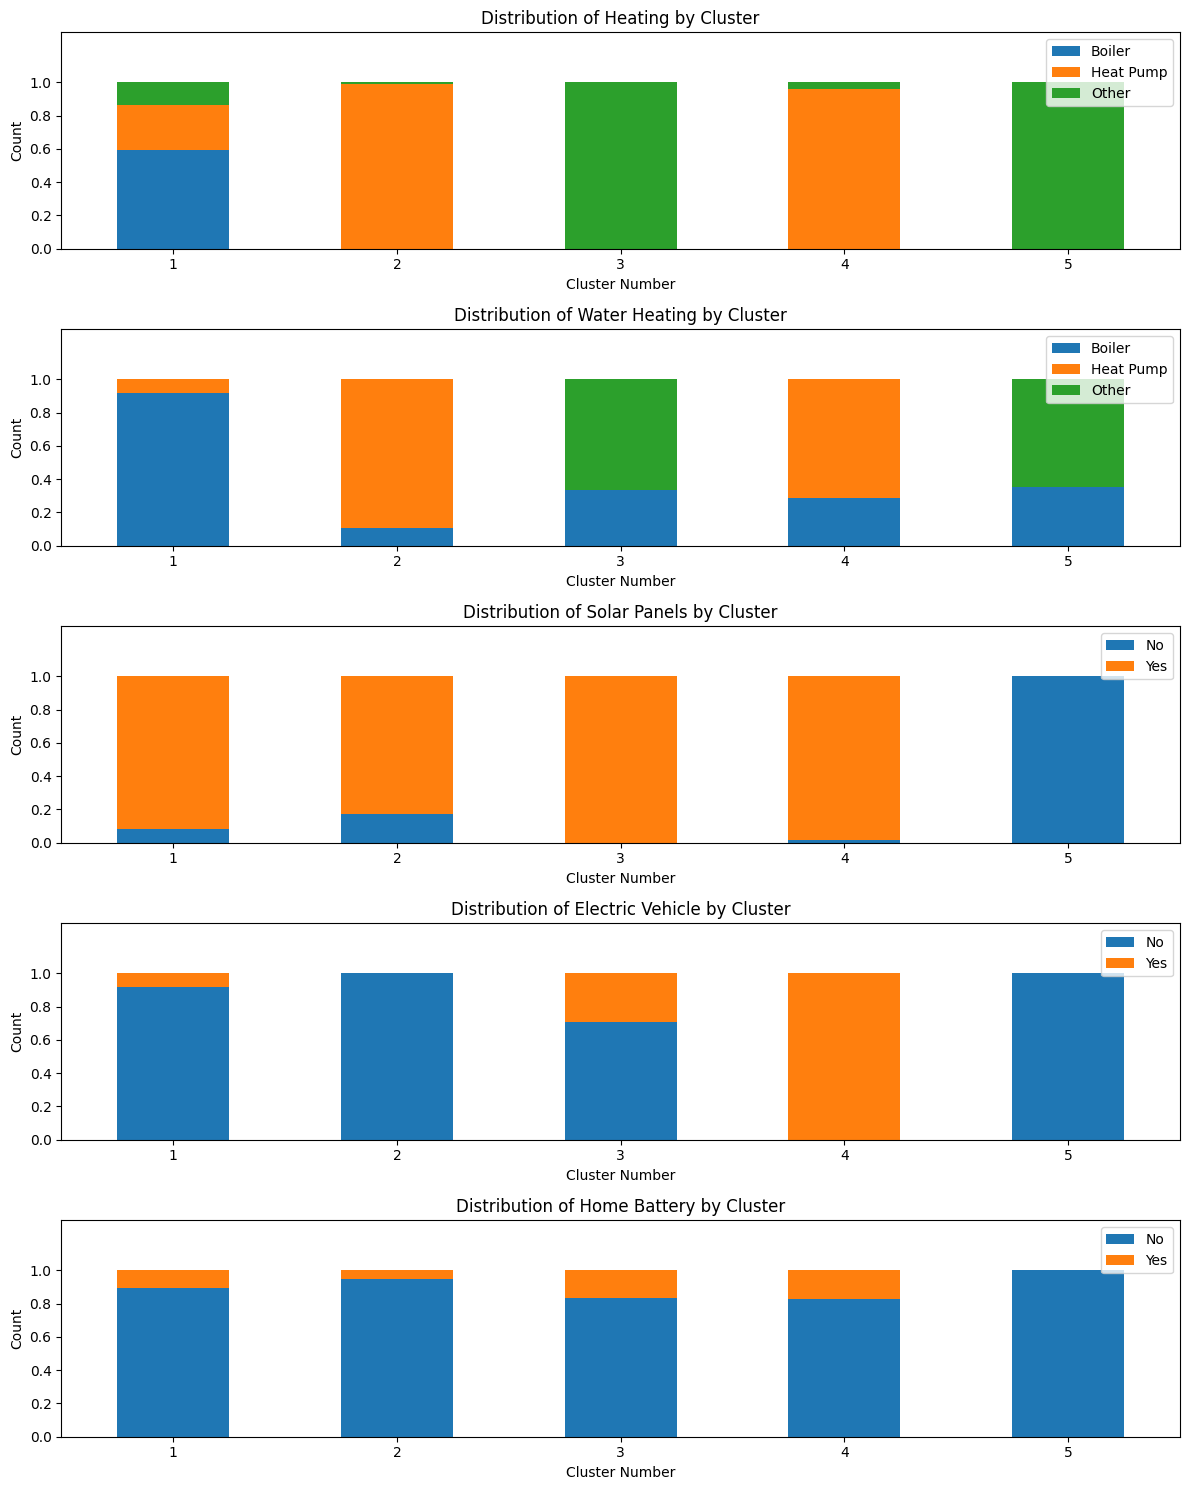

In [97]:
# Plot stacked bar charts for categorical feature distributions per cluster

if categorical_features == "technical":
    if building_type == "flat":
        category_features = ['Individual Electric Boiler', 'Individual Washing Machine']

    else:
        category_features = ['Heating', 'Water Heating', 'Solar Panels', 'Electric Vehicle', 'Home Battery']

else:
    category_features = ['Tenant Type', 'Age', 'Income', 'Education', 'Employment', 'Number of Residents', 'Number of Days at Home' ]

n_features = len(category_features)
fig, axes = plt.subplots(n_features, 1, figsize=(12, 3 * n_features))

if n_features == 1:
    axes = [axes]

for i, feature in enumerate(category_features):
    ax = axes[i]
    # Group and pivot data for plotting
    counts = df.groupby(['cluster', feature]).size().unstack(fill_value=0)
    proportions = counts.div(counts.sum(axis=1), axis=0)
    
    # Plot stacked bar chart
    proportions.plot(kind='bar', stacked=True, ax=ax)
    
    # Titles and labels
    ax.set_title(f'Distribution of {feature} by Cluster')
    ax.set_ylabel('Count')
    ax.set_xlabel('Cluster Number')
    ax.set_ylim(0, 1.3)
    ax.set_yticks(np.arange(0, 1.01, 0.2))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.legend(
    #title='Category',
    loc='upper right',
    bbox_to_anchor=(1, 1),
    ncol=1,
    fontsize='medium'
)
plt.tight_layout()
plt.show()